# Train a model to differ between this two kind of flowers
Train the model using the created dataset and save the model to use it in the future Flask app.

In [ ]:
!unzip -q "/content/drive/MyDrive/flower_dataset.zip" -d "/content/flower_dataset"

## Choose a model to decide which features are in each group
We will made some experiments to choose the best model to do it. At first we will train as a base model a home built Convolutional neural network.
### Load the dataset
TensorFlow makes it easy to load images from directories using the image_dataset_from_directory method.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define the path to the dataset
dataset_path = 'flower_dataset'

# Load the dataset
batch_size = 32
img_height = 180
img_width = 180

train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 768 files belonging to 2 classes.
Using 615 files for training.
Found 768 files belonging to 2 classes.
Using 153 files for validation.


## Preprocess the Data
You can use the prefetch and cache methods to optimize loading speed. Data augmentation is also a good practice to increase the diversity of your training dataset.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),  # Flips the images both horizontally and vertically.
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),  # Rotates the images by up to 20% of 360 degrees.
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),  # Zooms into the images by up to 20%.
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Translates the images up to 10% vertically and horizontally.
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),  # Randomly adjusts the contrast of the images by up to 10%.
])


## Create the model
We'll use a simple CNN architecture for this example. For more complex tasks, consider using a pre-trained model with transfer learning.


In [ ]:
from tensorflow.keras import regularizers
import tensorflow as tf

model = tf.keras.Sequential([
    data_augmentation,

    # Input layer with rescaling: Adjust according to your dataset
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),

    # Convolutional layer with L2 regularization
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Dropout layer
    tf.keras.layers.Dropout(0.2),

    # Another convolutional layer with L2 regularization
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Dropout layer
    tf.keras.layers.Dropout(0.2),

    # Flattening the convolutions
    tf.keras.layers.Flatten(),

    # Dense layer with L2 regularization
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Dropout layer before the output
    tf.keras.layers.Dropout(0.5),

    # Output layer
    tf.keras.layers.Dense(2, activation='softmax')
])

## Compile the model


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Metric to monitor
    patience=10,         # How many epochs to wait after last time the monitored metric improved
    verbose=1,          # To log when training is stopped
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored metric.
)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Evaluate the model

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


20/20 [==============================] - 3s 66ms/step - loss: 1.8240 - accuracy: 0.6634 - val_loss: 0.8445 - val_accuracy: 0.8954
Epoch 2/50
20/20 [==============================] - 1s 52ms/step - loss: 0.5941 - accuracy: 0.8878 - val_loss: 0.5821 - val_accuracy: 0.9020
Epoch 3/50
20/20 [==============================] - 1s 48ms/step - loss: 0.4988 - accuracy: 0.9008 - val_loss: 0.5940 - val_accuracy: 0.8824
Epoch 4/50
20/20 [==============================] - 1s 52ms/step - loss: 0.4135 - accuracy: 0.9317 - val_loss: 0.4955 - val_accuracy: 0.9150
Epoch 5/50
20/20 [==============================] - 1s 52ms/step - loss: 0.3490 - accuracy: 0.9561 - val_loss: 0.4481 - val_accuracy: 0.9150
Epoch 6/50
20/20 [==============================] - 1s 52ms/step - loss: 0.3070 - accuracy: 0.9626 - val_loss: 0.4272 - val_accuracy: 0.9281
Epoch 7/50
20/20 [==============================] - 1s 52ms/step - loss: 0.2942 - accuracy: 0.9528 - val_loss: 0.4117 - val_accuracy: 0.9281
Epoch 8/50
20/20 [======

In [ ]:
loss, acc = model.evaluate(val_ds)
print("Accuracy", acc)

5/5 [==============================] - 0s 13ms/step - loss: 0.3481 - accuracy: 0.9216
Accuracy 0.9215686321258545


# Base Model Documentation

## Dataset Loading and Preparation

- **Dataset**: `flower_dataset`, split into `girasoles` (sunflowers) and `rosas` (roses) subfolders.
- **Preprocessing**:
    - Resize images to 180x180 pixels.
    - Split the dataset into training and validation sets with an 80/20 ratio.
    - Normalize pixel values to a range of [0, 1].

## Model Architecture

- **Convolutional Neural Network (CNN) Model**:
    - Rescaling layer to normalize images.
    - Three convolutional layers with ReLU activation and max pooling.
    - Flatten layer to transition the output to dense layers smoothly.
    - A dense layer with 128 neurons and ReLU activation.
    - Output dense layer with 2 neurons (for sunflowers and roses) with softmax activation.

## Compilation and Training

- **Compilation**:
    - Optimizer: Adam.
    - Loss function: SparseCategoricalCrossentropy (with logits).
    - Metrics: Accuracy.
- **Training**:
    - 10 epochs, showing continuous improvement in accuracy and a decrease in loss.

## Results

- **Final Training Accuracy**: Approximately 98.86%.
- **Final Validation Accuracy**: Approximately 94.77%.

## Improvement Suggestions

1. **Early Stopping Implementation**

    To prevent overfitting and to select the best possible model without a fixed number of epochs, you can use an EarlyStopping callback in Keras. This stops training when a monitored metric has stopped improving.

2. **Regularization and Dropout**

    Adding Dropout layers can help prevent overfitting by randomly "turning off" a percentage of neurons during training. L2 regularization is another technique that penalizes large weights in the network, also helping to mitigate overfitting.

3. **Hyperparameter Tuning**

    Experimenting with different learning rates, batch sizes, and optimizers can lead to improvements in the model's accuracy and generalization.

4. **Advanced Architecture and Transfer Learning**

    Consider testing more complex network architectures or using pre-trained models like VGG16, ResNet, or MobileNet for Transfer Learning, which can be particularly beneficial if your dataset is relatively small.

5. **Data Augmentation**

    Although you initially decided against using data augmentation, this technique can improve the model's generalization ability by introducing variability into the training set. Keras offers several easy-to-implement data augmentation options.


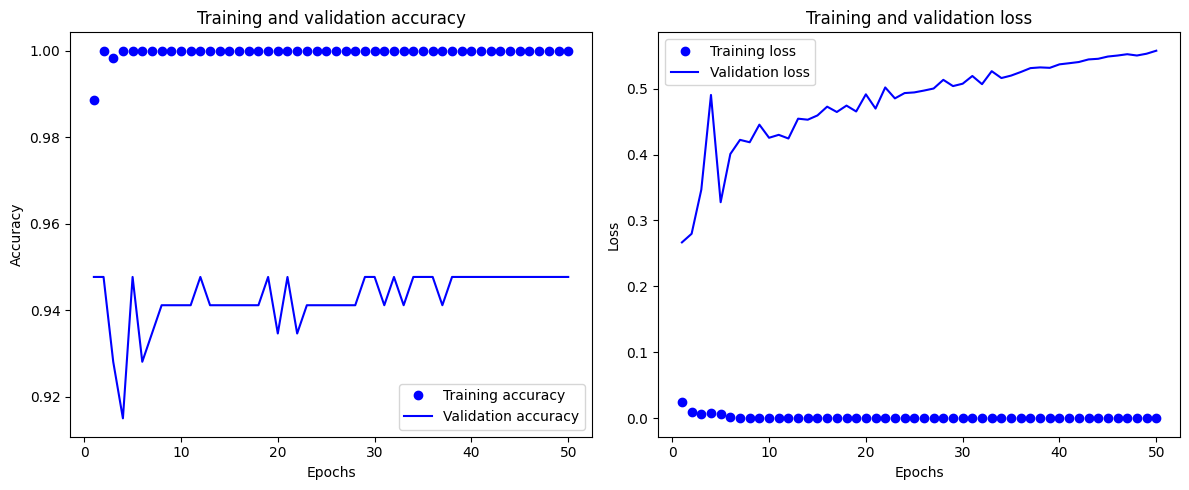

In [ ]:
import matplotlib.pyplot as plt

# Extract the history for accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 1. Model with early stopping
The results made by the early stopping in the validation loss. Probably is overfitting, we have to change it to eliminate this.

### Training Outcome with Early Stopping

Final Training Loss: Approximately 1.5526e-04, indicating the model has learned the training data exceptionally well to achieve such a low loss value.
Final Training Accuracy: 100%, showing the model perfectly classified all training images by the time training was stopped.
Validation Loss at Stopping: 0.4452, which is the metric monitored for early stopping. This suggests that while the model performs excellently on the training set, there is a notable discrepancy when predicting on unseen data, hinting at overfitting.
Validation Accuracy at Stopping: 93.46%, a strong performance on the validation set, although not as perfect as on the training set, which is typical and expected in machine learning models due to the generalization gap.

### Key Points

Early Stopping Triggered: The training stopped early at epoch 10, and the model weights were restored from the end of the best epoch based on the validation loss, which was epoch 5. This is a protective measure against overfitting, ensuring the model retained when it had the best generalization performance.
Overfitting Indication: The significant difference between the training accuracy (100%) and the validation accuracy (93.46%), along with a low training loss and relatively higher validation loss, suggests the model might be overfitting. The model has learned the training data too well, including its noise and outliers, which does not generalize perfectly on new, unseen data.
Restoring Best Weights: The callback restored the model's weights from the best epoch, aligning with the goal of early stopping to preserve the model state with the optimal balance between learning and generalization capabilities.

### Conclusion and Next Steps

Model Performance: Your model is very accurate on the training set but shows signs of overfitting, as evidenced by the early stopping mechanism kicking in due to a lack of improvement on the validation set.
Addressing Overfitting: Consider implementing strategies to further mitigate overfitting, such as introducing dropout layers, applying regularization techniques, or expanding your dataset (if possible) to improve the model's ability to generalize.
Evaluation and Tuning: It's recommended to evaluate the model on a separate test set (if available) to gauge its real-world performance. Further tuning of hyperparameters, model architecture, or training strategy may also yield improvements in both performance and generalization.



## Transfer learning example


In [ ]:
import tensorflow as tf

dataset_path = '/content/flower_dataset'  # Asegúrate de cambiar esto por la ruta real de tu dataset

batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 768 files belonging to 2 classes.
Using 615 files for training.
Found 768 files belonging to 2 classes.
Using 153 files for validation.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Cargar ResNet50 preentrenado sin la capa superior
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar el modelo base para no modificar los pesos durante el primer entrenamiento
base_model.trainable = False

# Crear la nueva cabeza del modelo (capas superiores) para la clasificación
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')  # Cambiar según el número de clases
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
epochs = 50  # Ajusta este valor según sea necesario
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[early_stopping])


Epoch 1/50
20/20 [==============================] - 4s 161ms/step - loss: 0.0276 - accuracy: 0.9902 - val_loss: 0.1850 - val_accuracy: 0.9608
Epoch 2/50
20/20 [==============================] - 3s 151ms/step - loss: 0.0216 - accuracy: 0.9919 - val_loss: 0.1130 - val_accuracy: 0.9673
Epoch 3/50
20/20 [==============================] - 4s 187ms/step - loss: 0.0131 - accuracy: 0.9951 - val_loss: 0.0912 - val_accuracy: 0.9739
Epoch 4/50
20/20 [==============================] - 4s 180ms/step - loss: 0.0083 - accuracy: 0.9984 - val_loss: 0.1020 - val_accuracy: 0.9804
Epoch 5/50
20/20 [==============================] - 3s 147ms/step - loss: 0.0187 - accuracy: 0.9935 - val_loss: 0.1269 - val_accuracy: 0.9608
Epoch 6/50
20/20 [==============================] - 4s 151ms/step - loss: 0.0223 - accuracy: 0.9886 - val_loss: 0.1253 - val_accuracy: 0.9739
Epoch 7/50
20/20 [==============================] - 3s 147ms/step - loss: 0.0098 - accuracy: 0.9967 - val_loss: 0.1057 - val_accuracy: 0.9739
Epoch 

In [ ]:
model.save('flowers_classification.h5')  # HDF5 format

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
